In [1]:
# This is  used to time the running of this notebook
import time
start_time = time.time()

In [90]:
import dill
dill.dump_session('Untitled.db')

In [1]:
import dill 
dill.load_session('Untitled.db')

In [2]:
%%time
# Download the data from the ENA https://www.ebi.ac.uk/ena/browser/view/SRR8426358
!wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR185/008/SRR1853178/SRR1853178_1.fastq.gz
!wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR185/008/SRR1853178/SRR1853178_2.fastq.gz

--2020-10-14 15:48:49--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR185/008/SRR1853178/SRR1853178_1.fastq.gz
           => ‘SRR1853178_1.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/fastq/SRR185/008/SRR1853178 ... done.
==> SIZE SRR1853178_1.fastq.gz ... 11853064187
==> PASV ... done.    ==> RETR SRR1853178_1.fastq.gz ... done.
Length: 11853064187 (11G) (unauthoritative)

100%[===================================>] 11,853,064,187  117MB/s   in 3m 0s  

2020-10-14 15:51:49 (62.9 MB/s) - ‘SRR1853178_1.fastq.gz’ saved [11853064187]

--2020-10-14 15:51:49--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR185/008/SRR1853178/SRR1853178_2.fastq.gz
           => ‘SRR1853178_2.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.sra.ebi.ac.u

In [3]:
!kb ref -d mouse -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-10-14 16:15:23,713]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2020-10-14 16:18:19,829]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz


In [5]:
# This command processes previously downloaded data
#%%time
!kb count --h5ad -i index.idx -g t2g.txt -x Dropseq -o output --filter bustools -t 4 \
SRR1853178_1.fastq.gz \
SRR1853178_2.fastq.gz

[2020-10-14 16:22:56,278]    INFO Generating BUS file from
[2020-10-14 16:22:56,278]    INFO         SRR1853178_1.fastq.gz
[2020-10-14 16:22:56,278]    INFO         SRR1853178_2.fastq.gz
[2020-10-14 16:47:45,379]    INFO Sorting BUS file output/output.bus to tmp/output.s.bus
[2020-10-14 16:48:52,442]    INFO Whitelist not provided
[2020-10-14 16:48:52,443]    INFO Generating whitelist output/whitelist.txt from BUS file tmp/output.s.bus
[2020-10-14 16:48:53,293]    INFO Inspecting BUS file tmp/output.s.bus
[2020-10-14 16:49:01,158]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist output/whitelist.txt
[2020-10-14 16:49:07,574]    INFO Sorting BUS file tmp/output.s.c.bus to output/output.unfiltered.bus
[2020-10-14 16:49:23,660]    INFO Generating count matrix output/counts_unfiltered/cells_x_genes from BUS file output/output.unfiltered.bus
[2020-10-14 16:49:32,198]    INFO Converting matrix output/counts_unfiltered/cells_x_genes.mtx to h5ad output/co

In [3]:
# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [4]:
# load the unfiltered matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [5]:
adata

AnnData object with n_obs × n_vars = 15601 × 55421
    var: 'gene_id', 'gene_name'

In [6]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 40

n_top_genes = 5000

n_bins = 20

flavor="seurat"

In [7]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

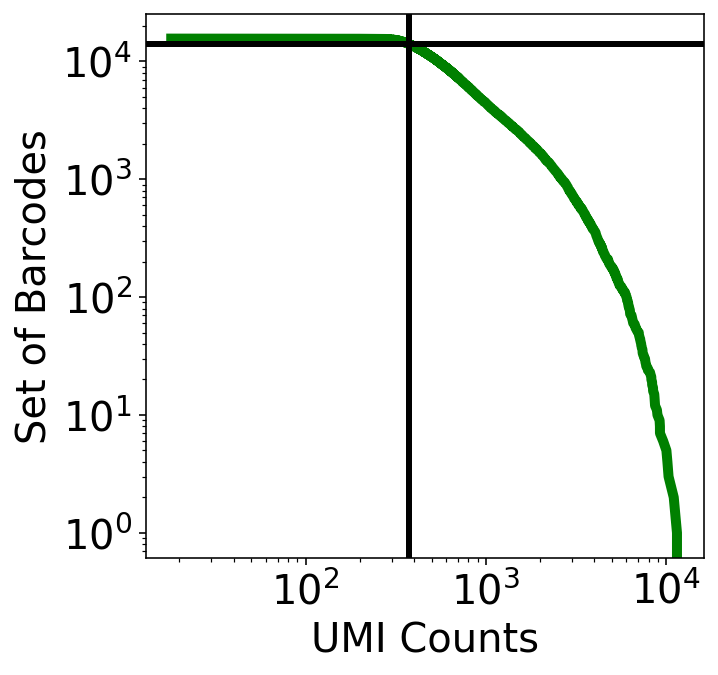

In [8]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells = 14000#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

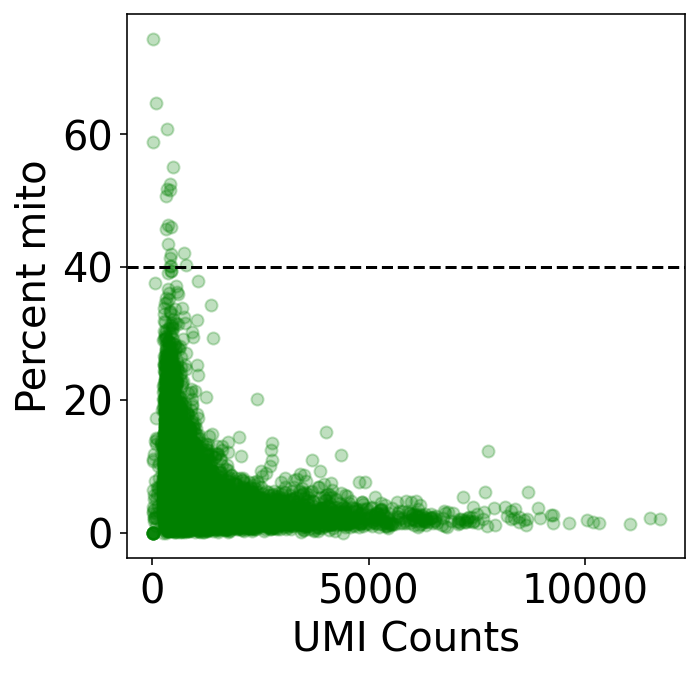

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(adata.obs["cell_counts"])
y = nd(adata.obs["percent_mito"])

ax.scatter(x, y, color="green", alpha=0.25)

ax.axhline(y=mito_criteria, linestyle="--", color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")

plt.show()

In [10]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [11]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [12]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 15,601 cells x 55,421 genes
    New shape: 15,549 cells x 23,054 genes


In [13]:
data = adata[cell_mask, gene_mask]

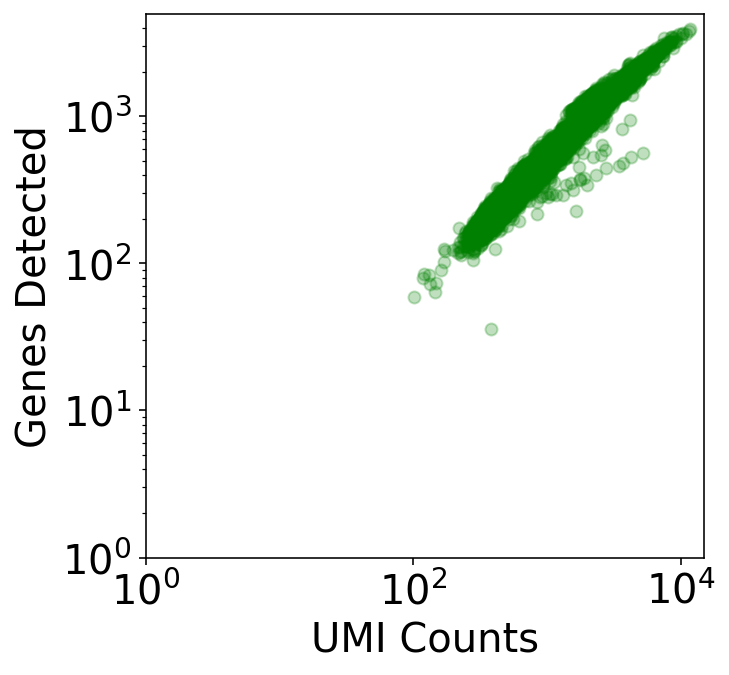

In [14]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(5, 5))

x = nd(data.X.sum(axis=1))
y = nd(np.sum(data.X>0, axis=1))

ax.scatter(x, y, color="green", alpha=0.25)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)

plt.show()

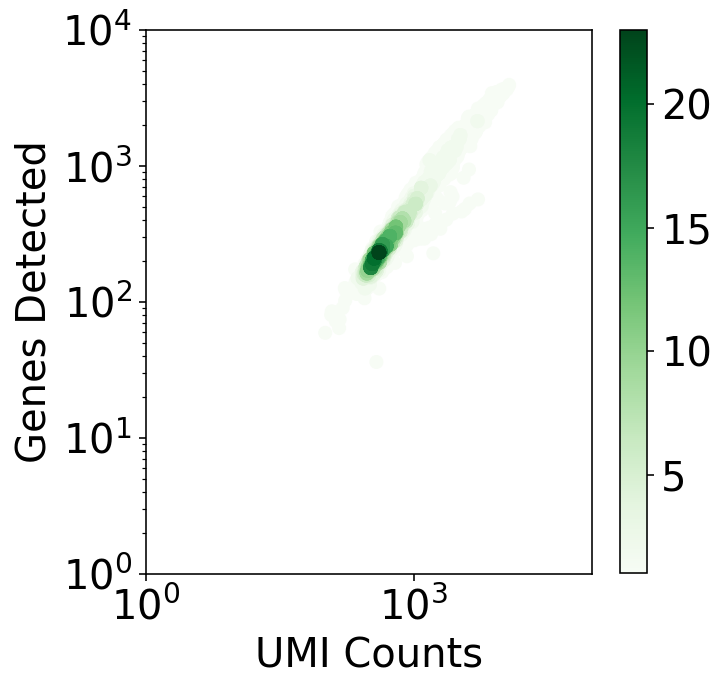

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

In [16]:
data

View of AnnData object with n_obs × n_vars = 15549 × 23054
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter'

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


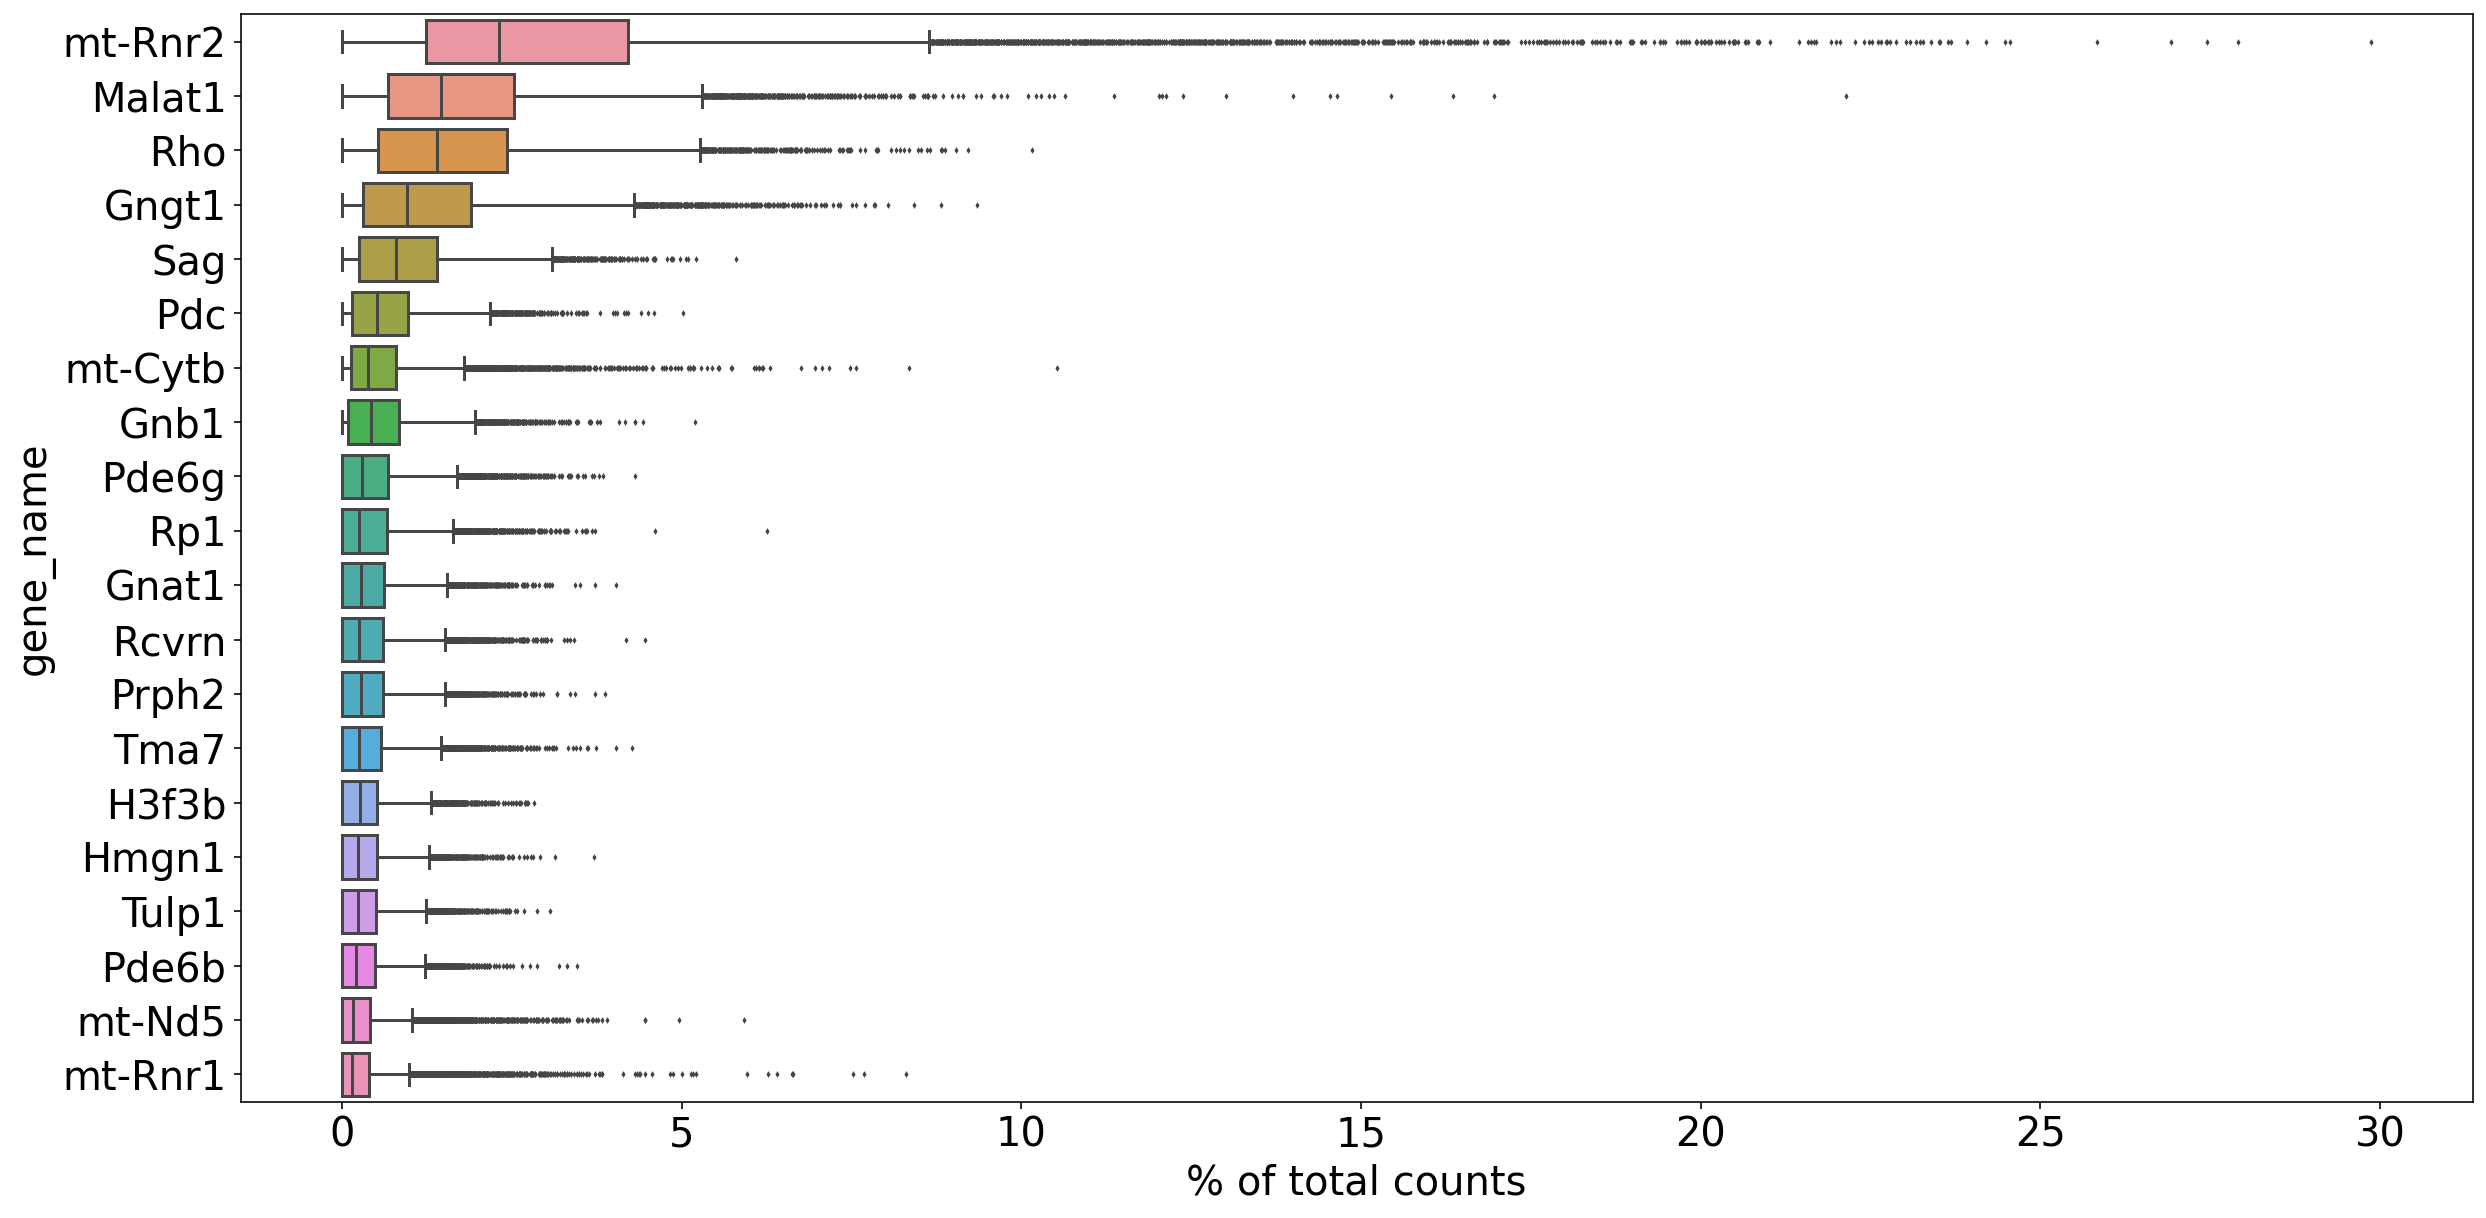

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
sc.pl.highest_expr_genes(data, n_top=20, ax = ax)

In [16]:
# setup

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

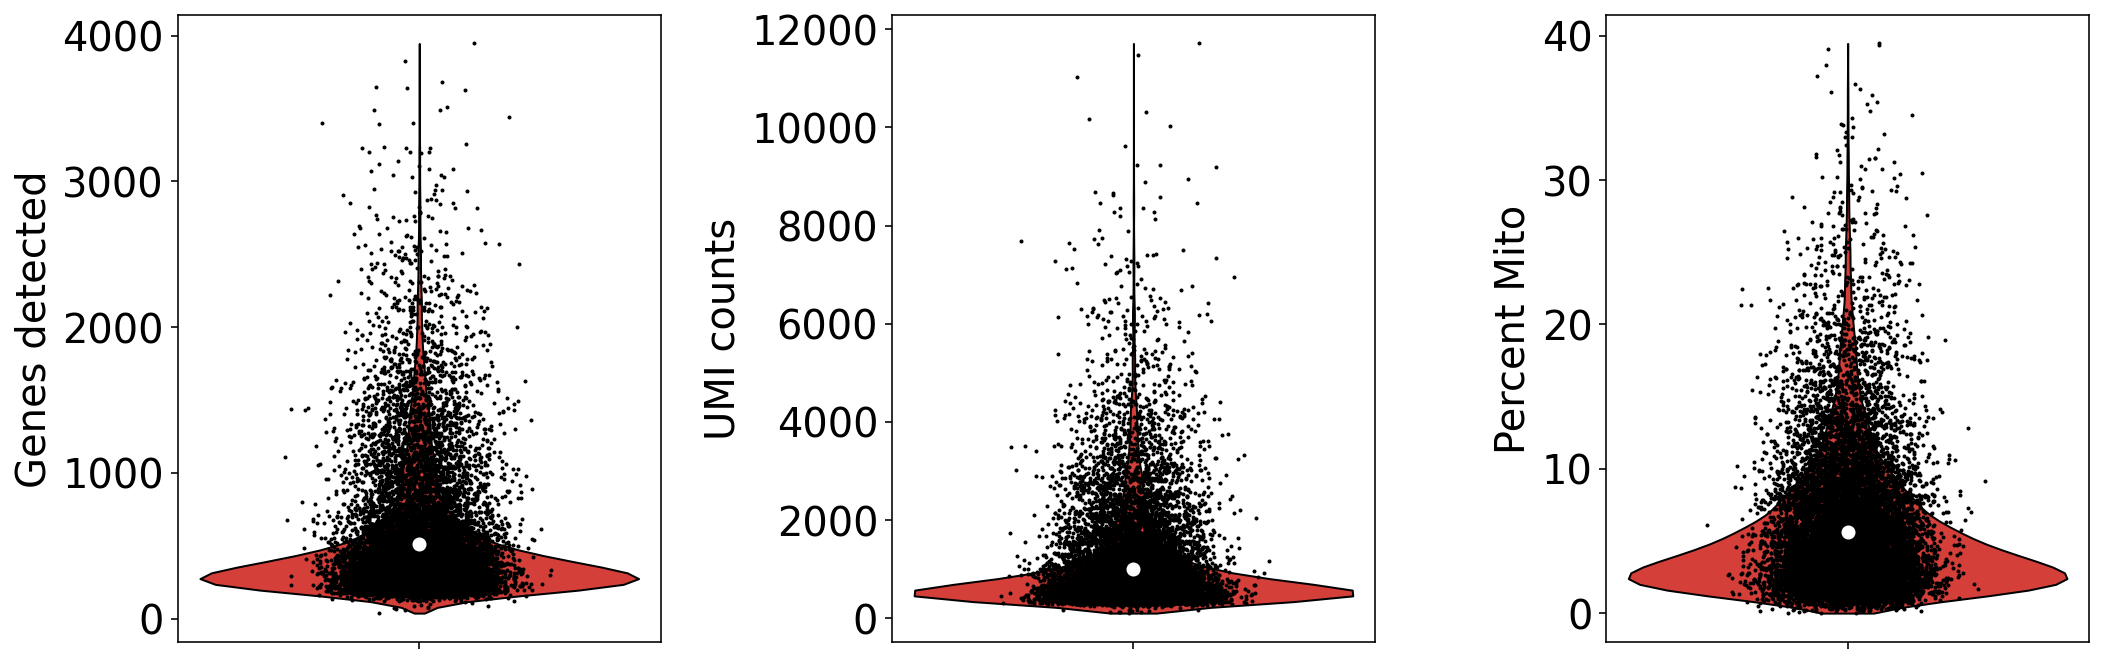

In [17]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = data.obs["n_genes"]
x2 = nd(data.X.sum(axis=1))
x3 = data.obs["percent_mito"]

vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])

ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")

plt.tight_layout()
plt.show()

In [18]:
data.layers["raw"] = data.X

In [19]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [20]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [21]:
data.X = data.layers["log1p"]

In [22]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values

In [23]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"].todense()
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

CPU times: user 12.2 s, sys: 11.6 s, total: 23.7 s
Wall time: 25.6 s


In [24]:
%%time
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 11.6 s, sys: 7.03 s, total: 18.6 s
Wall time: 4.43 s


In [25]:
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [26]:
sc.tl.leiden(data, random_state=state)

In [27]:
# t-SNE
X = data.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [28]:
# NCA
X = data.X
y = data.obs.leiden.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
data.obsm["X_nca"] = nca.fit_transform(X, y)

In [29]:
# t-SNE the NCA projection
X = data.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_nca_tsne"] = tsne.fit_transform(X)

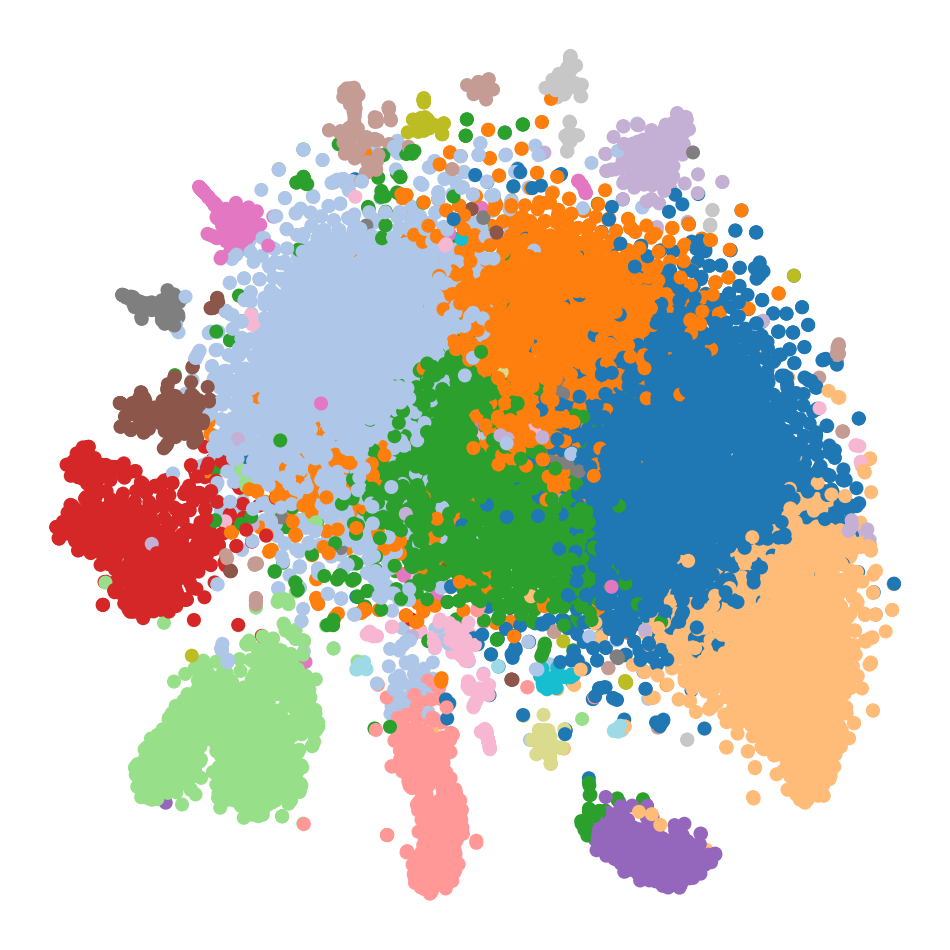

In [30]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_pca_tsne"][:,0]
y = data.obsm["X_pca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()

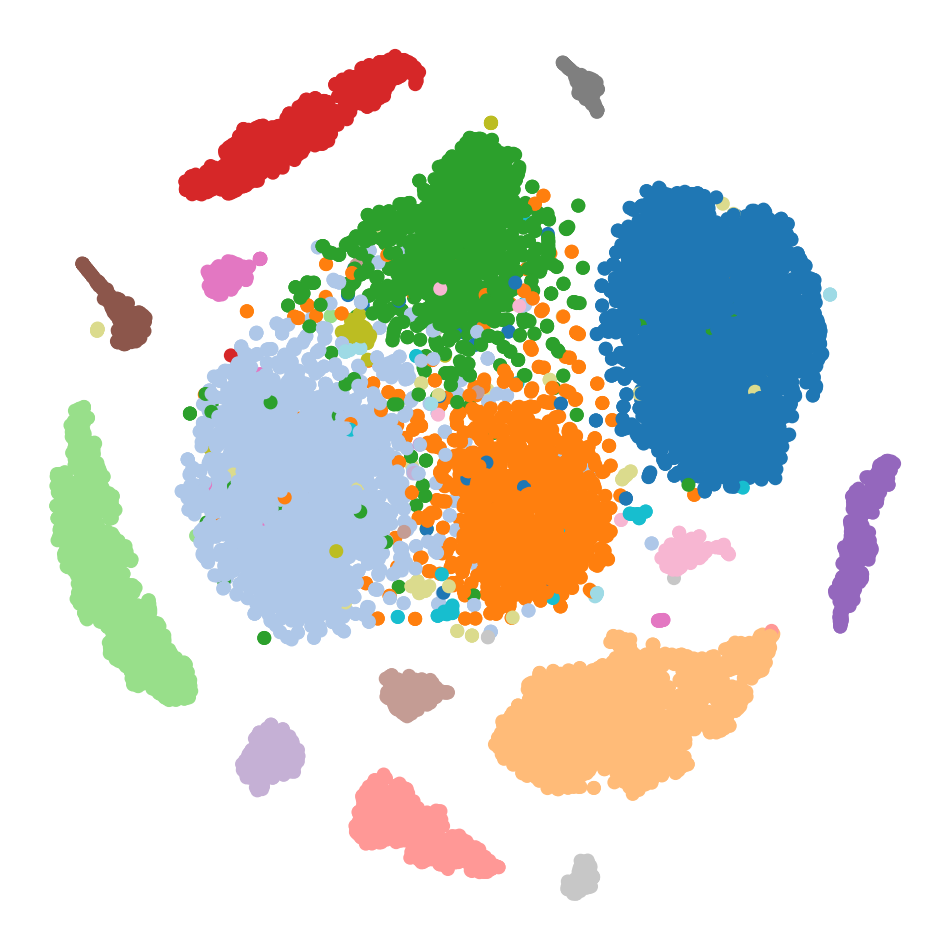

In [31]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()

... storing 'gene_name' as categorical


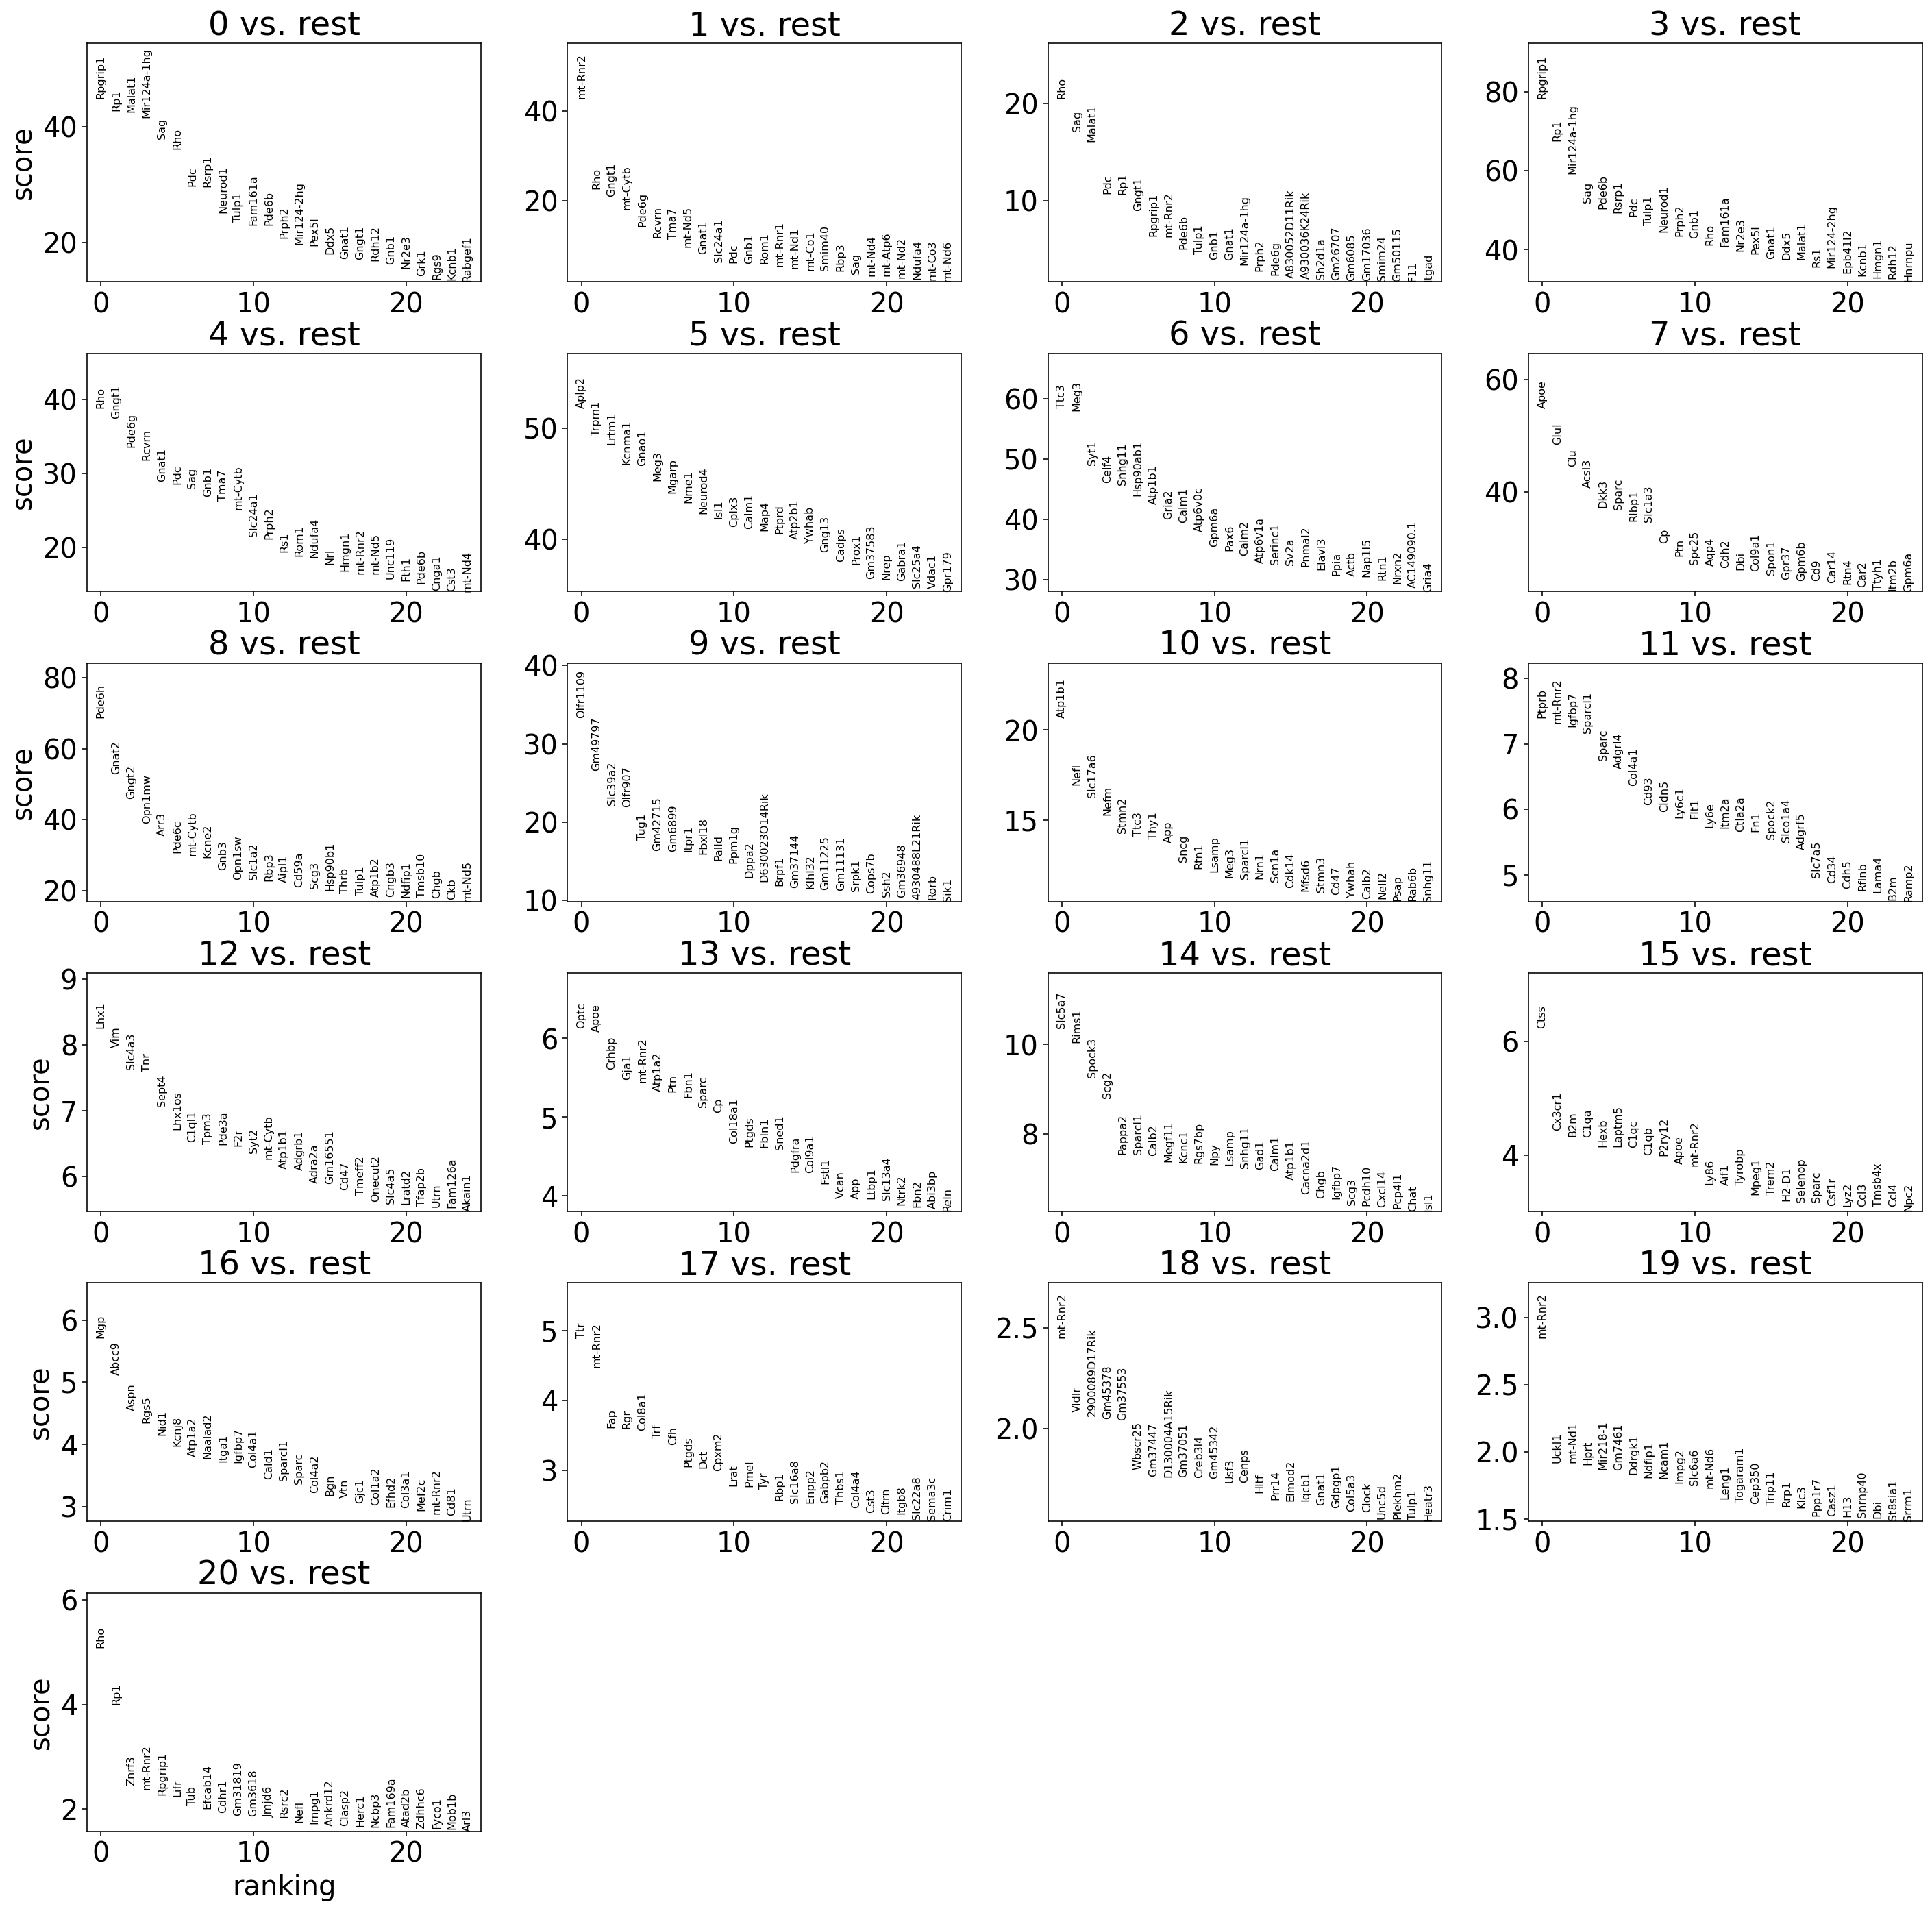

In [32]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

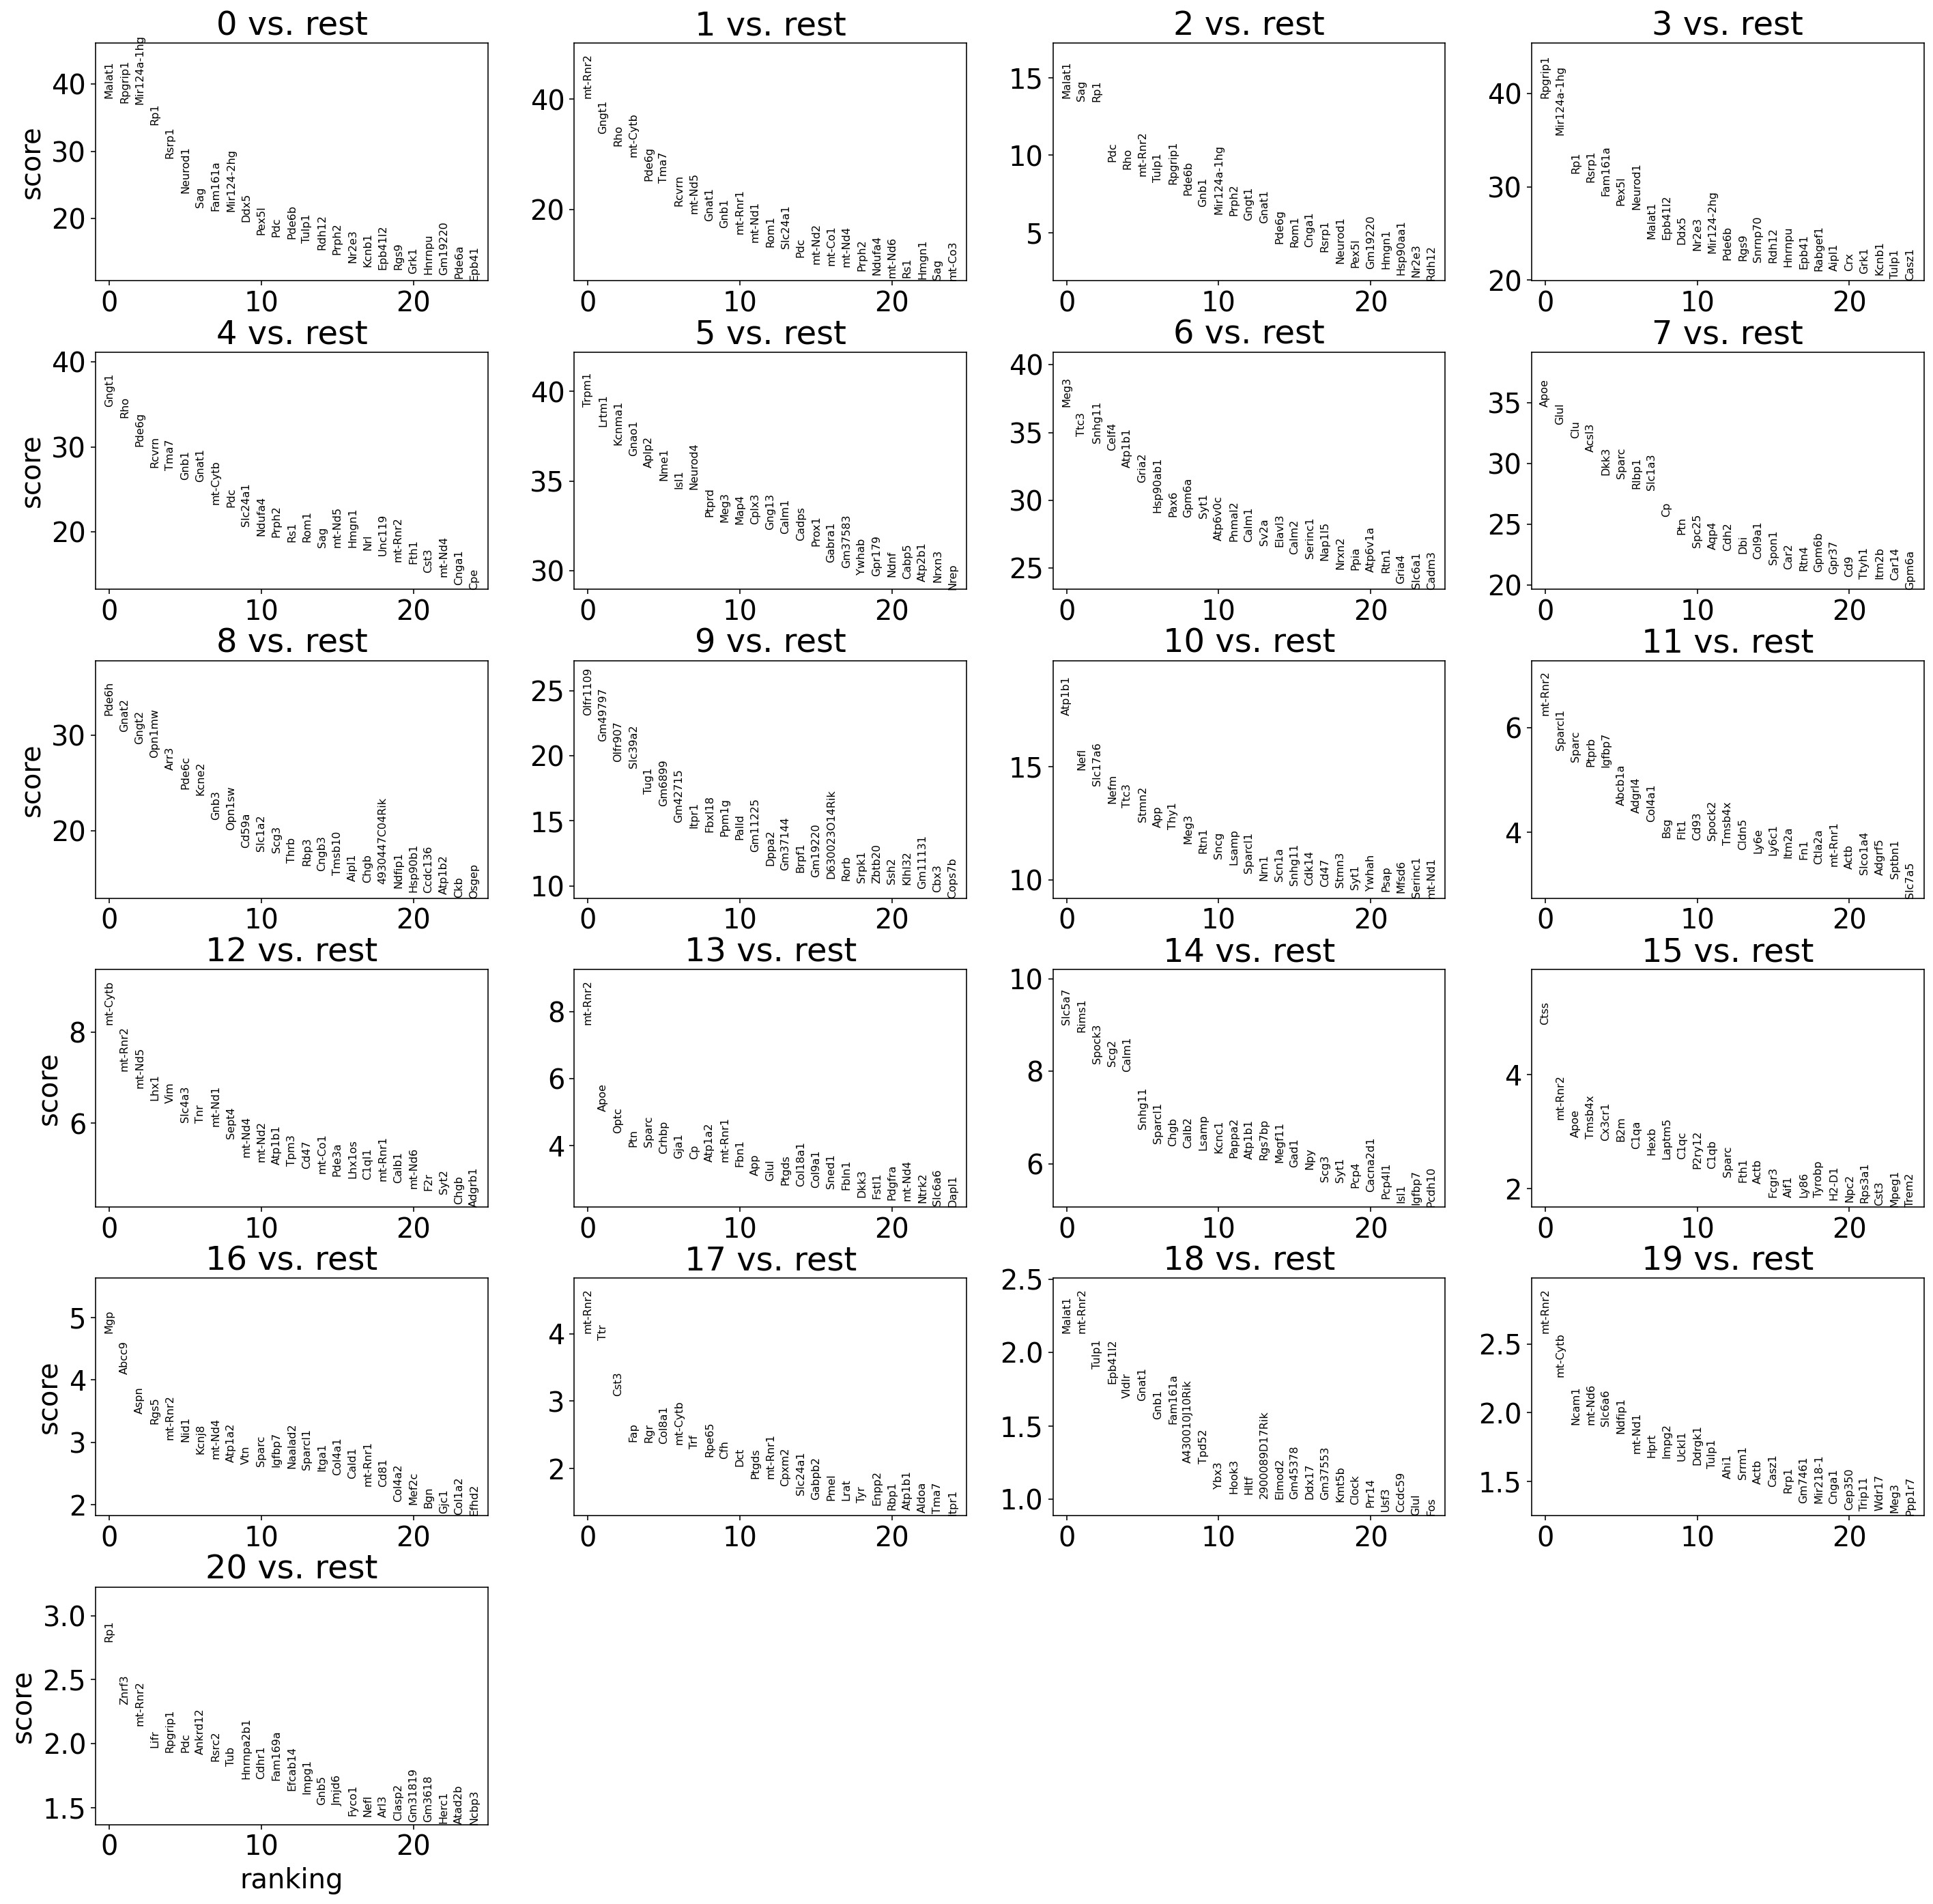

In [33]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(data,n_genes=25, sharey=False)

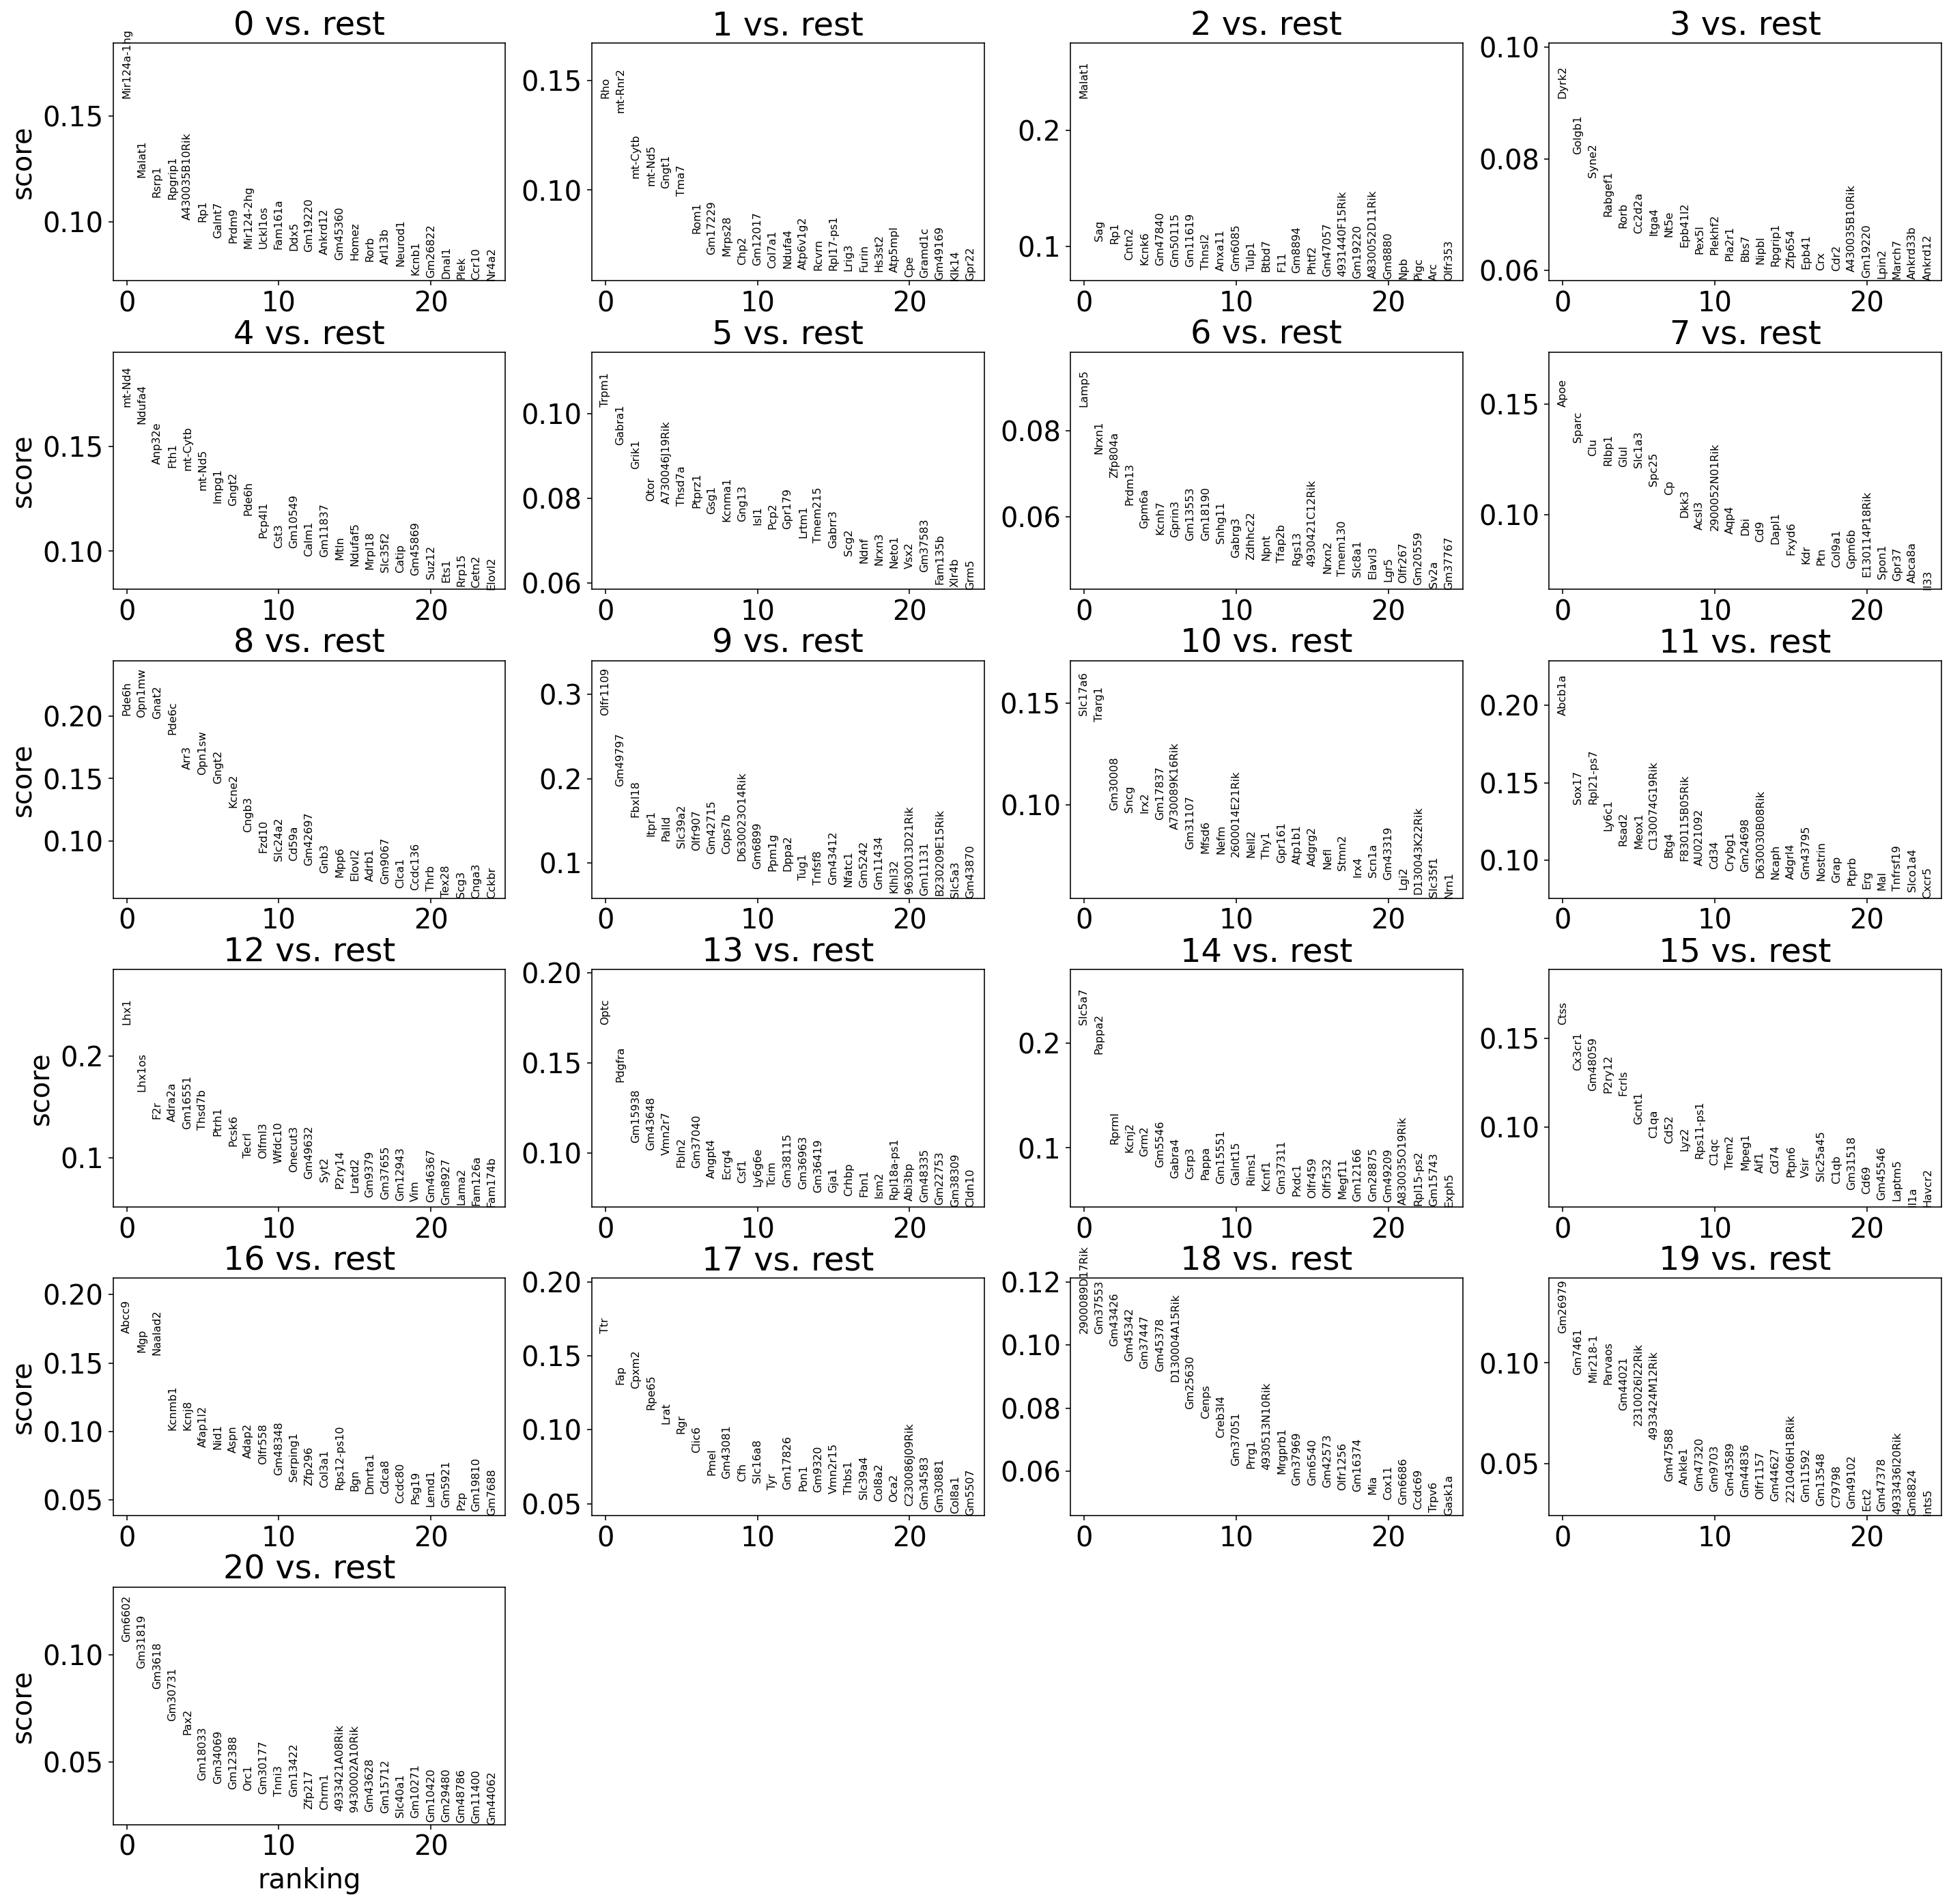

In [34]:
sc.tl.rank_genes_groups(data, 'leiden', method='logreg')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [35]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")

In [24]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',50)
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(500)

0              1              2              3  \
0           Malat1        mt-Rnr2         Malat1        Rpgrip1   
1          Rpgrip1          Gngt1            Sag    Mir124a-1hg   
2      Mir124a-1hg            Rho            Rp1            Rp1   
3              Rp1        mt-Cytb            Pdc          Rsrp1   
4            Rsrp1          Pde6g            Rho        Fam161a   
5          Neurod1           Tma7        mt-Rnr2          Pex5l   
6              Sag          Rcvrn          Tulp1        Neurod1   
7          Fam161a         mt-Nd5        Rpgrip1         Malat1   
8       Mir124-2hg          Gnat1          Pde6b        Epb41l2   
9             Ddx5           Gnb1           Gnb1           Ddx5   
10           Pex5l        mt-Rnr1    Mir124a-1hg          Nr2e3   
11             Pdc         mt-Nd1          Prph2     Mir124-2hg   
12           Pde6b           Rom1          Gngt1          Pde6b   
13           Tulp1        Slc24a1          Gnat1           Rgs9   
14           Rdh12            Pdc          Pde6g        Snrnp70   
15           Prph2         mt-Nd2           Rom1          Rdh12   
16           Nr2e3         mt-Co1          Cnga1         Hnrnpu   
17           Kcnb1         mt-Nd4          Rsrp1          Epb41   
18         Epb41l2          Prph2        Neurod1        Rabgef1   
19            Rgs9         Ndufa4          Pex5l          Aipl1   
20            Grk1         mt-Nd6        Gm19220            Crx   
21          Hnrnpu            Rs1          Hmgn1           Grk1   
22         Gm19220          Hmgn1       Hsp90aa1          Kcnb1   
23           Pde6a            Sag          Nr2e3          Tulp1   
24           Epb41         mt-Co3          Rdh12          Casz1   
25          Guca1b         Unc119          Cplx4          Ddx17   
26          Pcmtd2            Nrl          Rcvrn            Sag   
27           Cnga1            Cpe            Rs1         Slc4a7   
28         Rabgef1           Fth1          Pde6a         Samd11   
29             Mak        mt-Atp6         Unc119          Cngb1   
30         Snrnp70           Rbp3        Fam161a            Son   
31           Aipl1          Pde6b            Nrl          Cplx4   
32             Dmd         Smim40  A930036K24Rik          Pde6a   
33          Fam57b          Cnga1     Mir124-2hg         Pcmtd2   
34           Cabp4           Ybx1         Fam57b        Ankrd12   
35          Slc4a7          Cox6c            Mak            Dmd   
36           Ddx17          Rplp1           Ddx5          Pnisr   
37           Pnisr          Rps29         Sh2d1a           Ybx3   
38          Samd11          Rps14        Gm10717         Fam57b   
39            Mdm1         mt-Co2        Gm26707          Rbm25   
40           Cplx4         Pabpc1  A830052D11Rik         Guca1b   
41         Tax1bp1           Prcd          Ush2a          Cabp4   
42           Hmgn1           Oaz1         Smim24            Mak   
43           Casz1          Rps28          Hcls1           Mdm1   
44         Ankrd12            Vtn         Klhl21         Cep290   
45           Gnat1        Gm10800        Olfr600          Prph2   
46        AI847159          Tulp1          Kcnk6          Nxnl1   
47             Crx          Rps24        Gm10801         Tnrc6b   
48            Gnb1          Acbd7         Gdpgp1          Amer2   
49             Son      Rps13-ps6        Gm48236           Mpp4   
50           Nxnl1        Gm15610        Gm50115           Nktr   
51        Hsp90aa1        Gm11560        Gm17036        Tax1bp1   
52           Amer2          Klk14        Rbm12b1            Pdc   
53         Gm26822        Gm18829        Gm45105          Kif1b   
54          Rgs9bp          mt-Tv        Gm45244          Upf3b   
55           Rbm25        Gm13340  4933413L06Rik         Luc7l3   
56           Mat2a         Gm3355         Gm6085           Dgke   
57            Glmn           Tpt1        Gm42791       AI847159   
58          Pdzph1     Rpl13a-ps1        Slc24a1          Prom1 

In [25]:
genes = pd.DataFrame(data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(data.uns['rank_genes_groups']['pvals']).to_numpy()

In [26]:
unique = np.unique(data.obs.leiden.values.astype(int)).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [27]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [40]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'leiden'})

In [41]:
markers_gene.drop_duplicates(["leiden"]) # just showing the top candidate per cluster

leiden gene_name       p_value
0           0    Malat1             0
23054       1   mt-Rnr2             0
46108       2    Malat1   9.63686e-43
69162       3   Rpgrip1             0
92216       4     Gngt1   6.0005e-264
115270      5     Trpm1             0
138324      6      Meg3  5.57615e-298
161378      7      Apoe   2.1039e-263
184432      8     Pde6h  1.17611e-225
207486      9  Olfr1109  3.15086e-118
230540     10    Atp1b1   1.15077e-66
253594     11   mt-Rnr2   4.44294e-10
276648     12   mt-Cytb   3.04758e-16
299702     13   mt-Rnr2   2.53974e-14
322756     14    Slc5a7   1.93467e-19
345810     15      Ctss   1.06928e-06
368864     16       Mgp   2.02192e-06
391918     17   mt-Rnr2   6.05496e-05
414972     18    Malat1     0.0329441
438026     19   mt-Rnr2    0.00987563
461080     20       Rp1     0.0051713

In [42]:
def vplot_de(x, unique, specific_gene, specific_cluster, ax):
    unique = unique.astype(str)
    labels = unique
    lidx = np.arange(1, len(labels)+1)  # the label locations
    midx = np.where(unique==specific_cluster)[0][0]
    
    
    parts = ax.violinplot(x, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(parts['bodies']):
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        if pcidx == midx:
            pc.set_facecolor('#D43F3A')
            
    mean = [np.mean(i) for i in x]
    ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)
    
    ax.set_ylabel("$log(CPM + 1)$".format(specific_gene))
    ax.set_xticks(lidx)
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title("{} gene in cluster {}".format(specific_gene, specific_cluster))
    
    return ax

In [43]:
specific_cluster = markers_gene.drop_duplicates(["leiden"])["leiden"].values
specific_gene = markers_gene.drop_duplicates(["leiden"])["gene_name"].values

In [44]:
unique

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'], dtype='<U21')

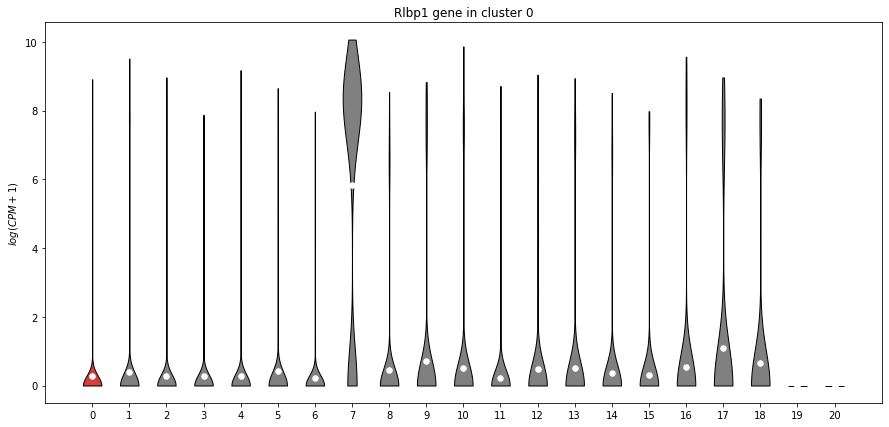

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))

spec_c = markers_gene[markers_gene.gene_name=="Rlbp1"]["leiden"].values[0]
spec_g = "Rlbp1"

x = []
for c in unique:
    x.append(nd(data[data.obs.leiden==str(c)][:,data.var.gene_name==spec_g].layers["log1p"].todense()).tolist())
    
vplot_de(x, unique, spec_g, spec_c, ax=ax)

ax.set_ylabel("$log(CPM+1)$")

plt.show()

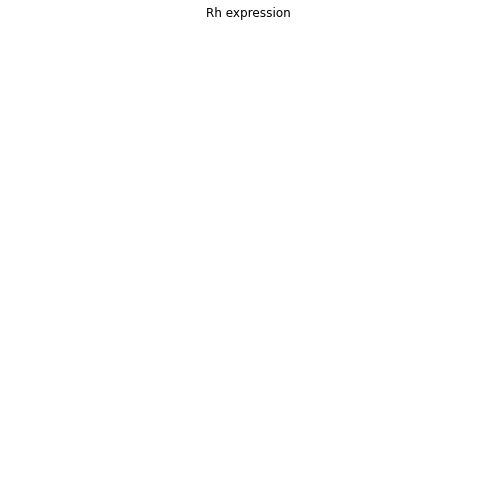

In [40]:
gene = "Rh"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()

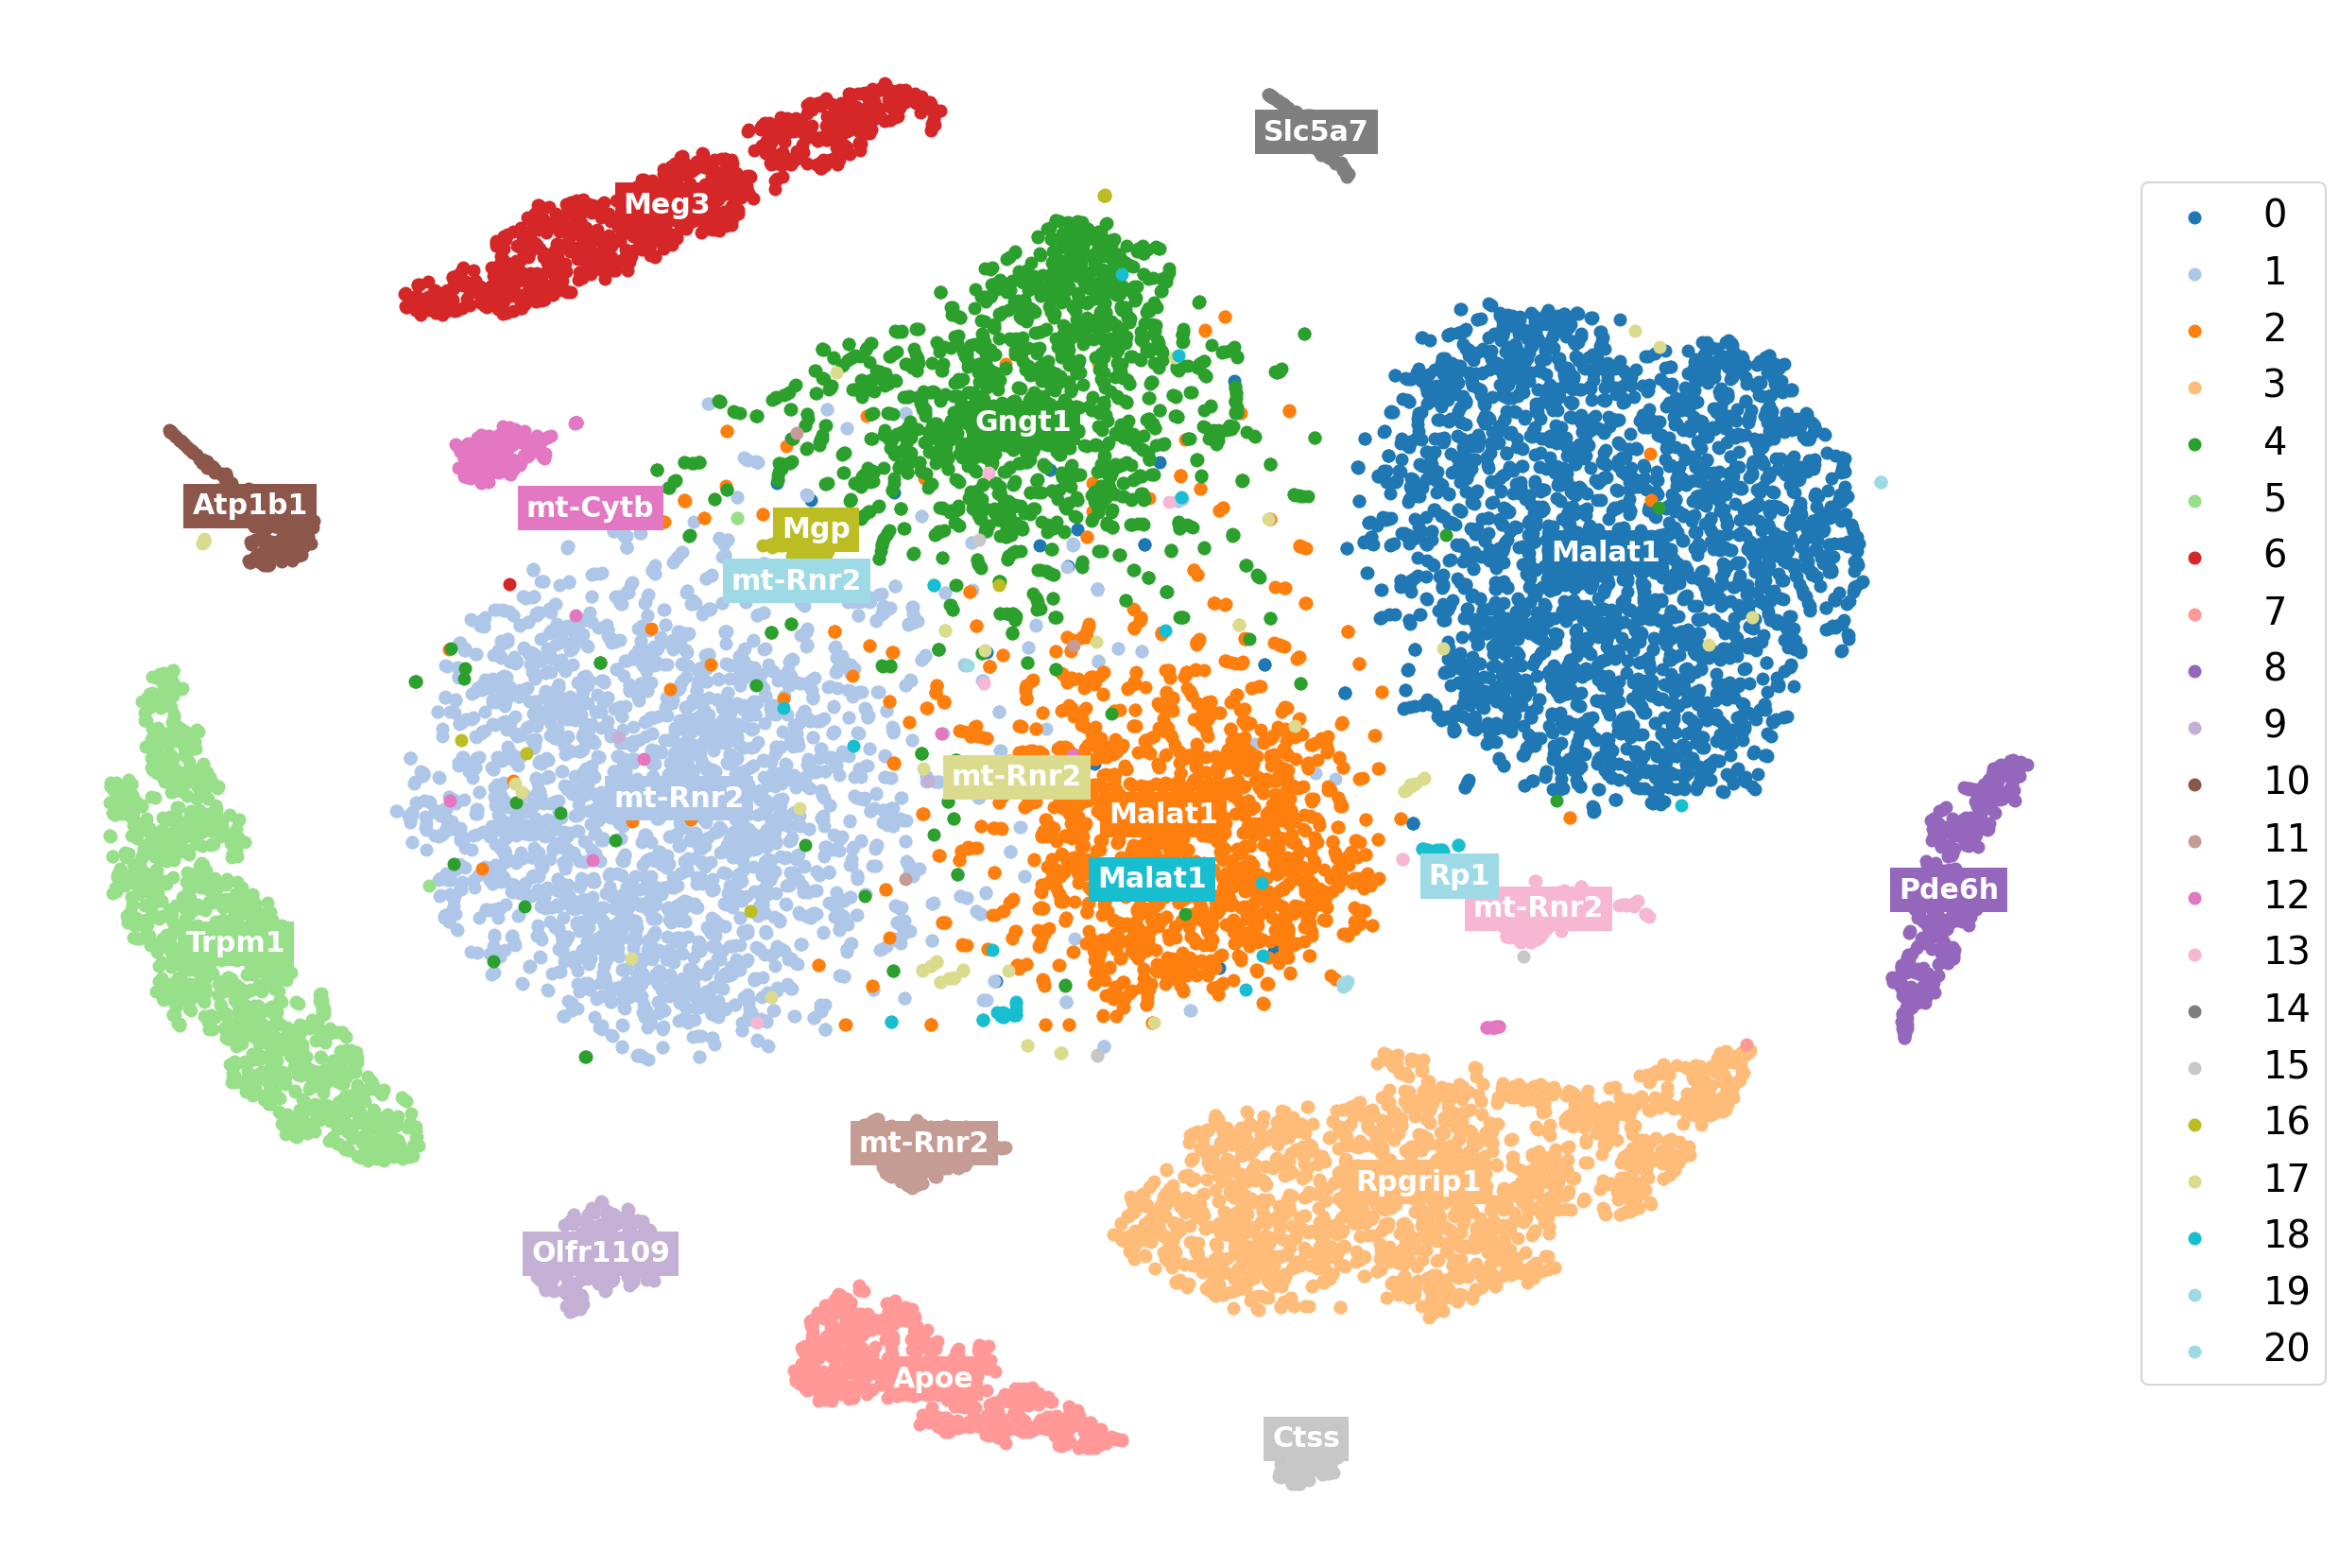

In [47]:
fig, ax = plt.subplots(figsize=(20,15))

c = np.unique(data.obs["leiden"].values.astype(int)).astype(str)
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, specific_gene)):
    XX = data[data.obs.leiden == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

In [48]:
top_idx = [np.where(i == data.var.gene_name.values)[0][0] for i in specific_gene]

In [49]:
mat = data.layers["norm"].todense()
obs = data.obs
var = data.var

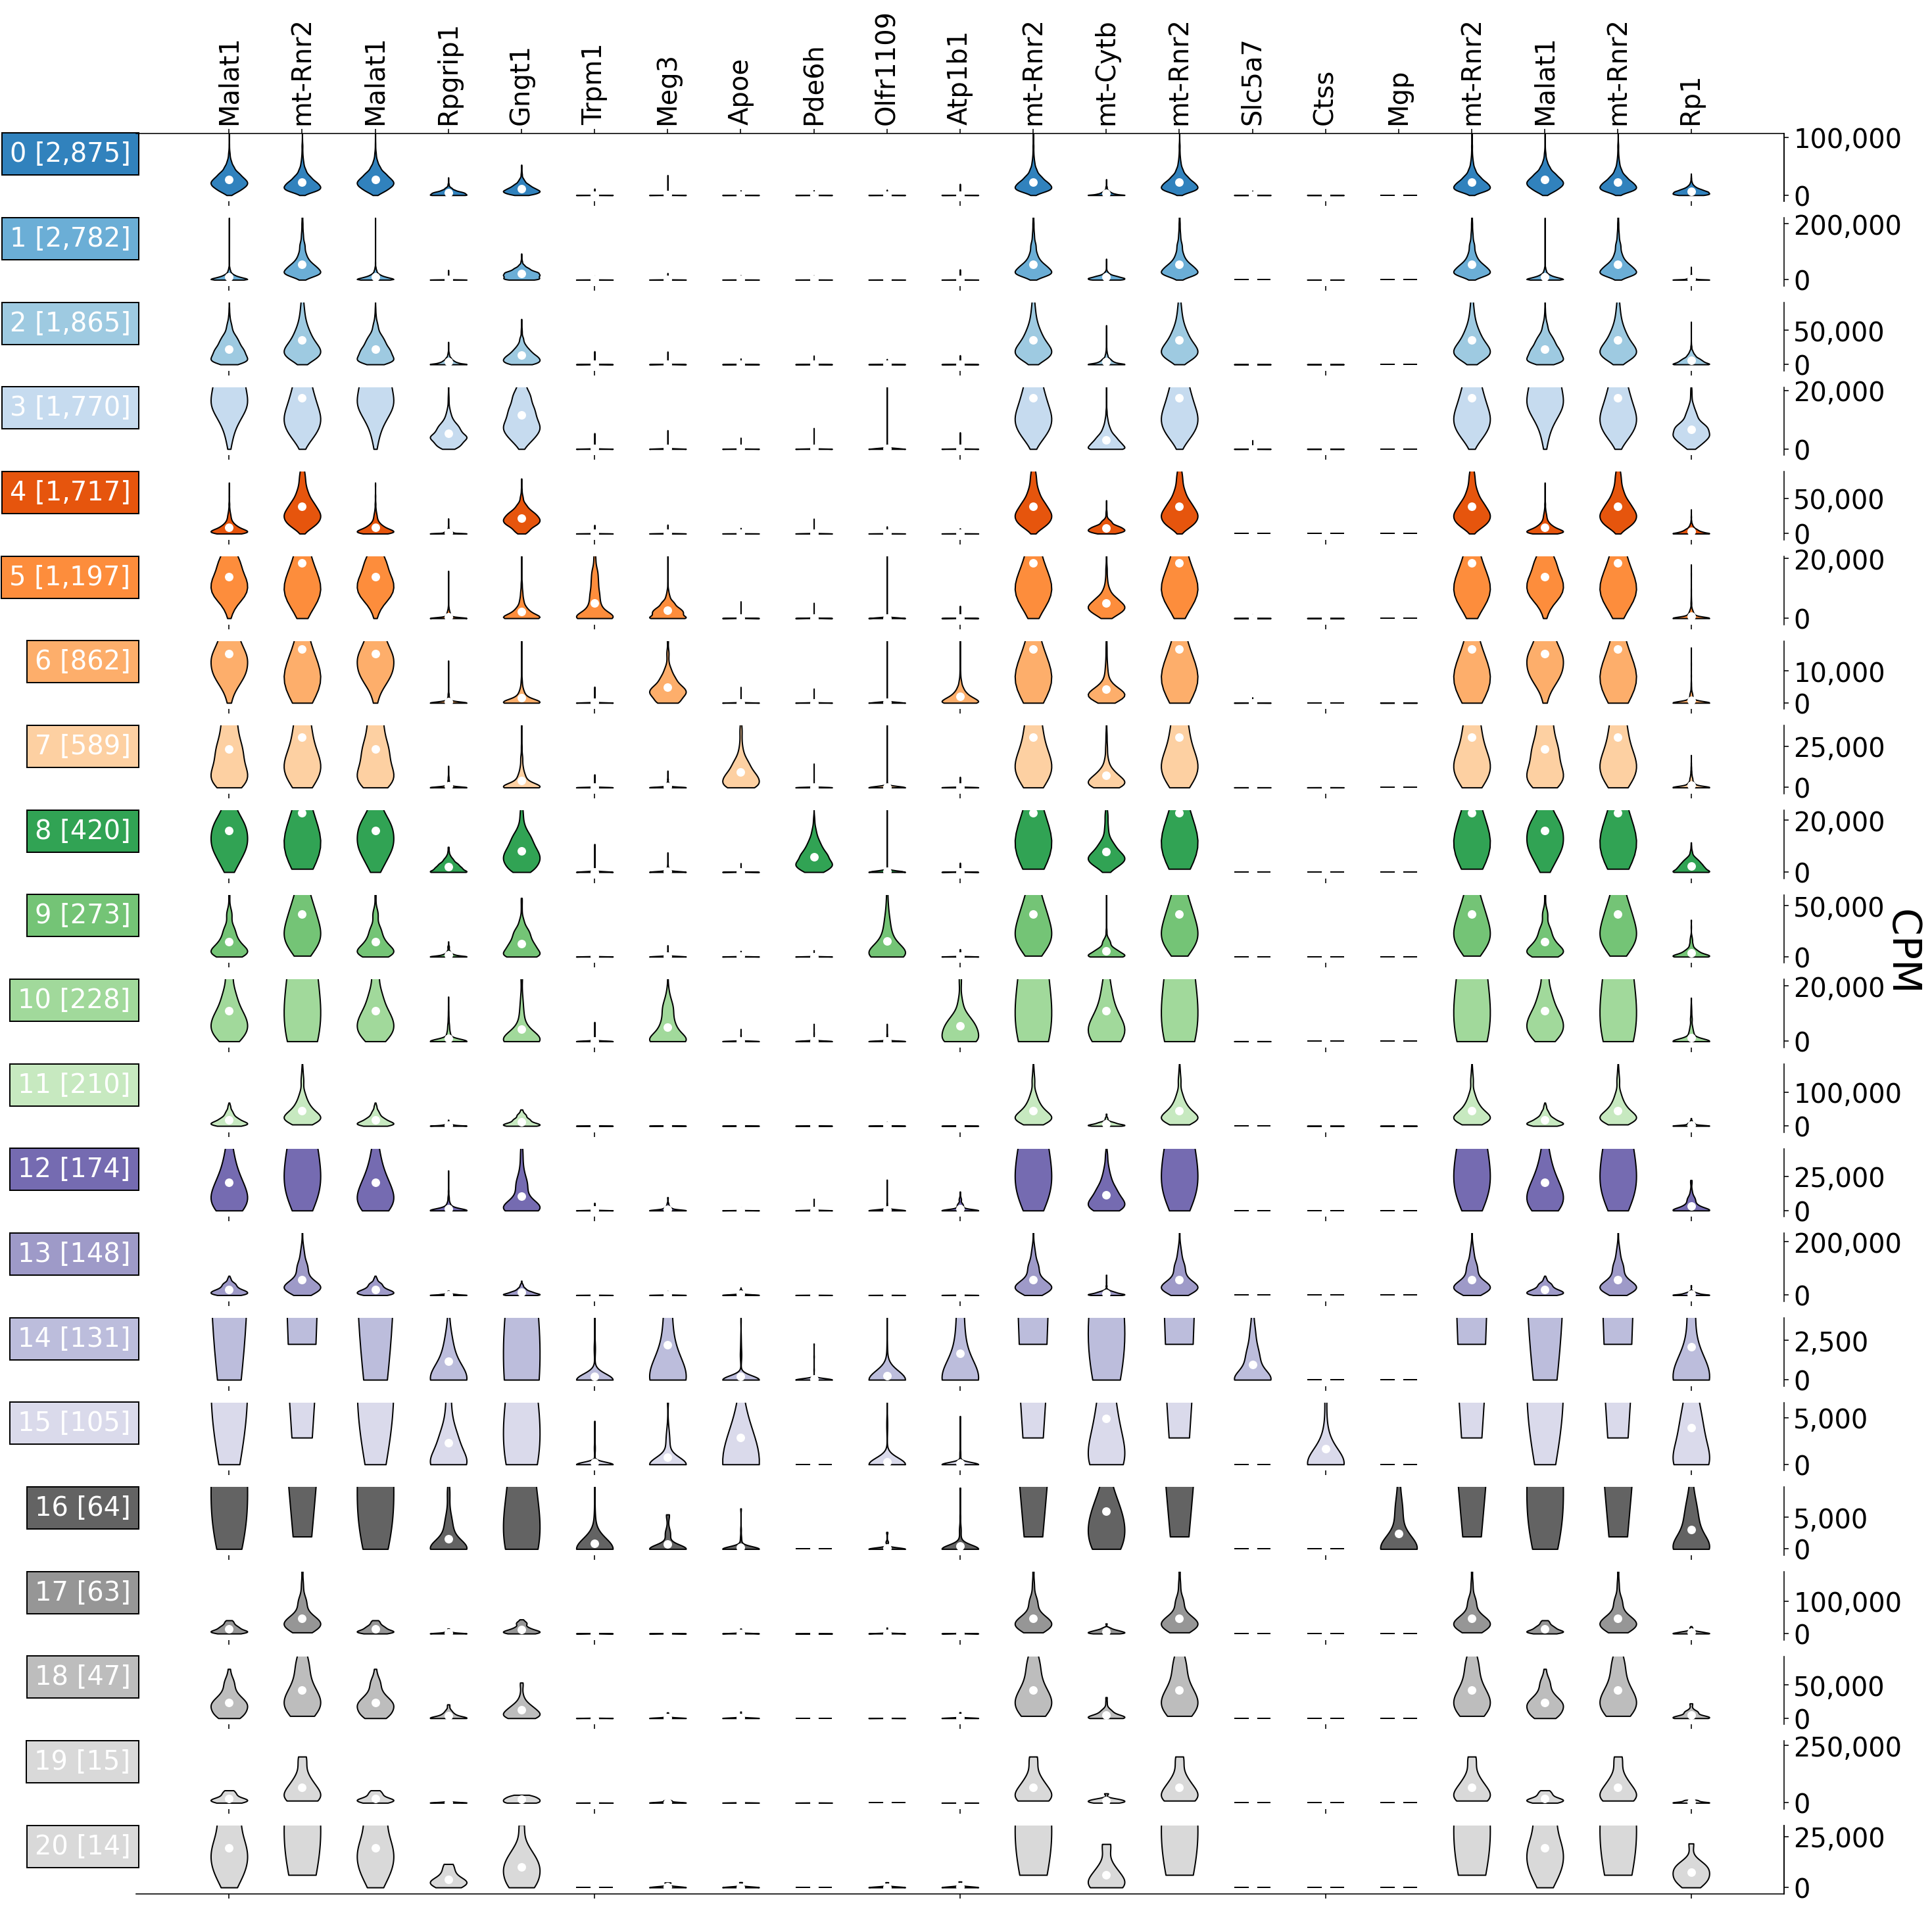

In [50]:
fig, axs = plt.subplots(figsize=(20,20), nrows=len(unique))
fig.subplots_adjust(wspace=0, hspace=0)


labels = specific_gene
lidx = np.arange(0, len(top_idx), 1)
means = []

for cidx, (c, ax) in enumerate(zip(unique, axs)):
    tmp_mat = mat[obs.leiden==str(c),:]
    
    x = tmp_mat[:,top_idx]
    means.append(nd(np.median(x,axis=0)))

    v = ax.violinplot(x.T.tolist(), showmedians=False, showextrema=False, positions=lidx)

    for pcidx, pc in enumerate(v['bodies']):
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_facecolor(cm.tab20c(cidx))
        

    means = [np.mean(i) for i in x.T]
    ax.scatter(lidx, means, marker='o', color='white', s=30, zorder=3)
 
    if cidx==0:
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(lidx)
        ax_top.set_xticklabels(labels, rotation=90, ha="center")
        ax_top.spines["top"].set_visible(True)
        ax_top.spines["left"].set_visible(False)
        ax_top.spines["bottom"].set_visible(False)
    if cidx == len(unique)-1:
        ax_bot = ax.twiny()
        ax_bot.set_xticks([])
        ax_bot.set_xticklabels([])
        ax_bot.spines["top"].set_visible(False)
        ax_bot.spines["left"].set_visible(False)
        ax_bot.spines["bottom"].set_visible(True)

    ax.set_xticklabels("")
    ax.yaxis.tick_right()
    ax.set_ylabel("{} [{:,}]".format(c, x.shape[0]), color="white",rotation="horizontal", ha="right",bbox=dict(boxstyle="square",ec="black",fc=cm.tab20c(cidx)))
    

    
    lim = nd(x.mean(axis=0))[cidx]*4
    
    ax.set_ylim(-lim*0.1, lim)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

        
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.text(1, 0.5, 'CPM ', ha='center', va='center', rotation=270, fontsize=30)
plt.show()

In [64]:
markers = ["Pax6"]
features = data.var.gene_name.values

In [65]:
midx = [np.where(i==features)[0][0] for i in markers]

In [66]:
assignments = data.obs.leiden.values

In [67]:
# for each cluster for each gene get two things
# 1 percent of cells in the cluster expressing that gene
# 2 average expression of that gene (for cells that are expressing it)


per = np.zeros((len(unique), len(markers)))
avg = np.zeros((len(unique), len(markers)))

mtx = data.layers["log1p"]#.todense()


for cn, c in enumerate(unique):
    tmp_mtx = mtx[assignments==c]
    sub_mtx = tmp_mtx[:,midx]
    
    avg[cn] = nd(sub_mtx.mean(axis=0))
    per[cn] = (sub_mtx>0).sum(axis=0)/sub_mtx.shape[0]

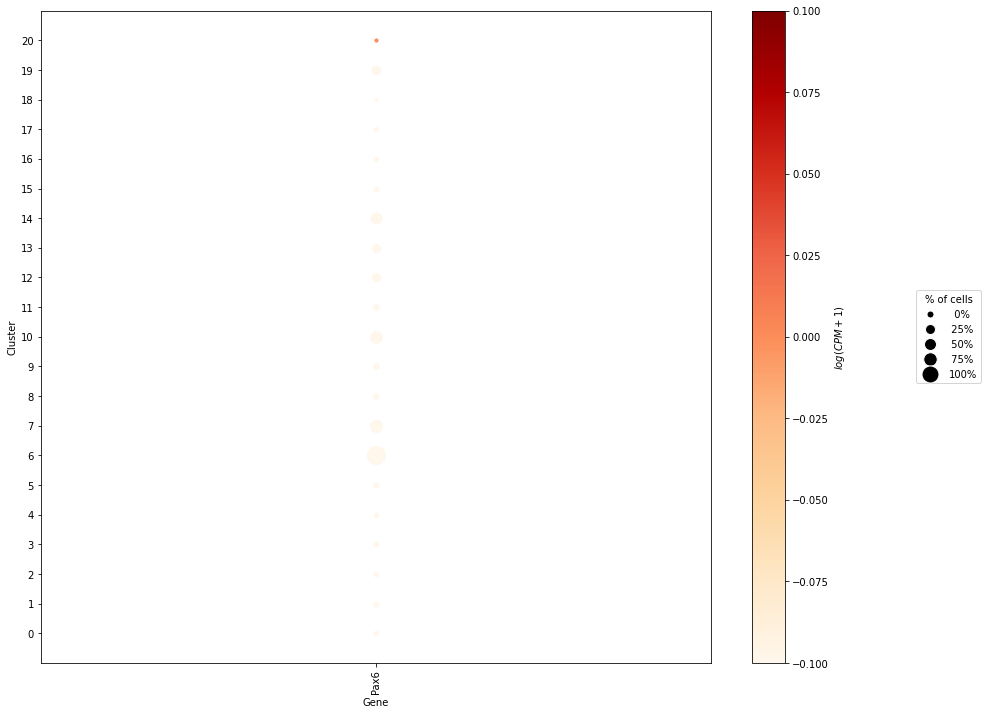

In [2]:
fig, ax = plt.subplots(figsize=(15,12))
xidx = np.arange(len(markers))
yidx = np.arange(len(unique))

xlabels = markers
ylabels = unique

X, Y = np.meshgrid(xidx, yidx)


for dn, d in enumerate(per):
    a = ax.scatter(X[dn],Y[dn], s=d*500+10, c = avg[dn], cmap="OrRd")

ax.set_xticks(xidx)
ax.set_yticks(yidx)

ax.set_xticklabels(xlabels, rotation=90, ha="center")
ax.set_yticklabels(ylabels)

ax.set_xlabel("Gene")
ax.set_ylabel("Cluster")

ax.figure.colorbar(a, ax=ax, label="$log(CPM+1)$")

handles =  [Line2D([0], [0], marker='o', color='w', label='  0%',markerfacecolor='black', markersize=7),
            Line2D([0], [0], marker='o', color='w', label=' 25%',markerfacecolor='black', markersize=10),
            Line2D([0], [0], marker='o', color='w', label=' 50%',markerfacecolor='black', markersize=12),
            Line2D([0], [0], marker='o', color='w', label=' 75%',markerfacecolor='black', markersize=13.5),
            Line2D([0], [0], marker='o', color='w', label='100%',markerfacecolor='black', markersize=17)]
ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.3,0.5), title="% of cells")

plt.show()